### Transfer learning fine tuning

In [1]:
##Import dataset
!wget https://www.dropbox.com/s/yvy9rjqjcte1fqr/dogs-cats-horses-humans-dataset.zip?dl=0

--2020-05-10 16:27:41--  https://www.dropbox.com/s/yvy9rjqjcte1fqr/dogs-cats-horses-humans-dataset.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.1, 2620:100:601b:1::a27d:801
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/yvy9rjqjcte1fqr/dogs-cats-horses-humans-dataset.zip [following]
--2020-05-10 16:27:42--  https://www.dropbox.com/s/raw/yvy9rjqjcte1fqr/dogs-cats-horses-humans-dataset.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucddbf869602e323916f37793902.dl.dropboxusercontent.com/cd/0/inline/A3fUpF5dsBqMThxwhyV_nADQXNL9JjoAZsK91eXkPfzEHcKG9CuhK5Y5CVlrqVqvrE9kMRZ1R7AvQGInlGNZR5IV0qQD0VWdpfnlzbr4l6v4p7_5wmnyGLOZS2HqmocNdqw/file# [following]
--2020-05-10 16:27:42--  https://ucddbf869602e323916f37793902.dl.dropboxusercontent.com/cd/0/inline/A3fUpF5dsBqMThxwhyV_nADQXNL9JjoAZsK91eXk

In [2]:
!unzip dogs-cats-horses-humans-dataset.zip?dl=0

Archive:  dogs-cats-horses-humans-dataset.zip?dl=0
  inflating: dataset/cats/cat.1.jpg  
  inflating: dataset/cats/cat.10.jpg  
  inflating: dataset/cats/cat.100.jpg  
  inflating: dataset/cats/cat.101.jpg  
  inflating: dataset/cats/cat.102.jpg  
  inflating: dataset/cats/cat.103.jpg  
  inflating: dataset/cats/cat.104.jpg  
  inflating: dataset/cats/cat.105.jpg  
  inflating: dataset/cats/cat.106.jpg  
  inflating: dataset/cats/cat.107.jpg  
  inflating: dataset/cats/cat.108.jpg  
  inflating: dataset/cats/cat.109.jpg  
  inflating: dataset/cats/cat.11.jpg  
  inflating: dataset/cats/cat.110.jpg  
  inflating: dataset/cats/cat.111.jpg  
  inflating: dataset/cats/cat.112.jpg  
  inflating: dataset/cats/cat.113.jpg  
  inflating: dataset/cats/cat.114.jpg  
  inflating: dataset/cats/cat.115.jpg  
  inflating: dataset/cats/cat.116.jpg  
  inflating: dataset/cats/cat.117.jpg  
  inflating: dataset/cats/cat.118.jpg  
  inflating: dataset/cats/cat.119.jpg  
  inflating: dataset/cats/cat.12.

In [3]:
ls

 dataset/  'dogs-cats-horses-humans-dataset.zip?dl=0'   sample_data/


In [4]:
### Getting the list of all the files in the folder
import os, shutil
folders = os.listdir("dataset/dataset")
print(folders)

['horses', 'humans', 'cats', 'dogs']


In [5]:
### Creating the directory for the images
if not os.path.isdir("val_images"):
    os.mkdir("val_images")
classes = ["dogs","cats","horses","humans"]
!ls

 dataset  'dogs-cats-horses-humans-dataset.zip?dl=0'   sample_data   val_images


In [0]:
###Creating the folders
for c in classes:
    p = os.path.join("val_images",c) #val_images/cats
    if not os.path.isdir(p):
        os.mkdir(p)

###Extracting the data
SPLIT = 0.9
for f in os.listdir("dataset/dataset"):
    path = "dataset/dataset/"+f
    imgs = os.listdir(path)
    
    split_size = int(SPLIT*len(imgs))
    files_to_move = imgs[split_size:]
    #print(len(files_to_move))
    #print(files_to_move)
    for img_f in files_to_move:
        src = os.path.join(path,img_f)
        dest = os.path.join("val_images/"+f,img_f)
        shutil.move(src,dest)

In [7]:
print("Training Data")
for f in folders:
    path = "dataset/dataset/"+f
    print(f+ " "+str(len(os.listdir(path))))
   

print("\n Validation Data") 
for f in folders:
    path = "val_images/"+f
    print(f+ " "+str(len(os.listdir(path))))

Training Data
horses 181
humans 181
cats 181
dogs 181

 Validation Data
horses 21
humans 21
cats 21
dogs 21


Using TensorFlow backend.


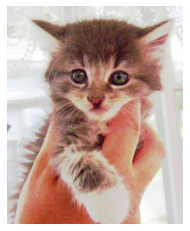

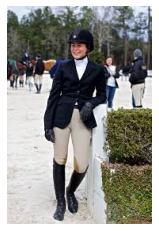

In [8]:
##Check if the images are correctly imported
from keras.preprocessing import image
from matplotlib import pyplot as plt

sample_path = "dataset/dataset/cats/cat.100.jpg"
img = image.load_img(sample_path)
x = image.img_to_array(img)/255.0
plt.imshow(img)
plt.axis("off")
plt.show()

sample_path = "dataset/dataset/humans/rider-103.jpg"
img = image.load_img(sample_path)
x = image.img_to_array(img)/255.0
plt.imshow(img)
plt.axis("off")
plt.show()

In [9]:
###As dataset is large we use train data generator
from keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(rescale=1.0/255,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.3,
    horizontal_flip = True
    )


val_gen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_gen.flow_from_directory(
    "dataset/dataset/",
    target_size = (224,224),
    batch_size = 32,
    class_mode = 'categorical'
)

val_generator = val_gen.flow_from_directory(
    "val_images/",
    target_size = (224,224),
    batch_size = 32,
    class_mode = 'categorical'
)

Found 724 images belonging to 4 classes.
Found 84 images belonging to 4 classes.


In [10]:
##Checking the shape
for x,y in train_generator:
    print(x.shape)
    print(y.shape)
    break

(32, 224, 224, 3)
(32, 4)


In [11]:
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np

model = ResNet50(include_top=False,weights='imagenet',input_shape=(224,224,3))
model.summary()

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________

In [12]:
from keras.layers import * 
from keras.models import Model
av1 = GlobalAveragePooling2D()(model.output)
fc1 = Dense(256,activation='relu')(av1)
d1 = Dropout(0.5)(fc1)
fc2 = Dense(4,activation='softmax')(d1)

model_new = Model(inputs=model.input,output=fc2)

model_new.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
____________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  


In [0]:
##Setting the rules for the backprop
for ix in range(len(model_new.layers)):
  model_new.layers[ix].trainable = False

In [0]:
# Train our model
from keras.optimizers import Adam
adam = Adam(lr=0.00003)
model_new.compile(optimizer='adam',metrics=['accuracy'],loss='categorical_crossentropy')

In [15]:
history = model_new.fit_generator(
    train_generator,
    epochs = 5,
    steps_per_epoch = 5,
    validation_data = val_generator,
    validation_steps = 4 
)

Epoch 1/5
5/5 [==============================] - 60s 12s/step - loss: 2.0607 - accuracy: 0.2688 - val_loss: 1.6255 - val_accuracy: 0.2414
Epoch 2/5
5/5 [==============================] - 54s 11s/step - loss: 2.0450 - accuracy: 0.2250 - val_loss: 1.5236 - val_accuracy: 0.2500
Epoch 3/5
5/5 [==============================] - 48s 10s/step - loss: 1.9457 - accuracy: 0.3176 - val_loss: 1.4455 - val_accuracy: 0.2596
Epoch 4/5
5/5 [==============================] - 52s 10s/step - loss: 1.9007 - accuracy: 0.3187 - val_loss: 1.4813 - val_accuracy: 0.2845
Epoch 5/5
5/5 [==============================] - 56s 11s/step - loss: 2.0717 - accuracy: 0.2438 - val_loss: 1.4659 - val_accuracy: 0.2155


In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss= history.history['val_loss']

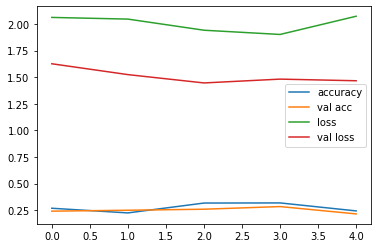

In [19]:
plt.plot(acc,label="accuracy")
plt.plot(val_acc,label="val acc")
plt.plot(loss,label='loss')
plt.plot(val_loss,label='val loss')
plt.legend()
plt.show()